In [1]:
#IPython is what you are using now to run the notebook
import IPython
# Pandas makes working with data tables easier
import pandas as pd
import matplotlib.pyplot as plt

import nltk as nltk
from sklearn import feature_extraction
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import numpy as np
import random
import re
import time

In [2]:
# color setting
# bcolors.BOLD
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# a function that get the top 15 words from each charactor and return a dictionary
# where keys are character names and values are dictionaries with their top 15 words and its corresponding ids

def top_words(data_topCast):
    
    office_list = ['Michael', 'Dwight', 'Jim', 'Pam', 'Oscar', 'Andy', 'Angela', 'Kevin', 'Erin']
    office_dic = {}

    for person in office_list:

        # fetching data for one person
        char_data = data_topCast[data_topCast["speaker"] == person]
        # char_sentiment = char_data[char_data["sentiment label"] == "neutral"]
        line = list(char_data.line_text) 
        index = list(char_data.id)

        # creating a list of all line_text and id
        line = list(zip(line, index))

        # tokenize each word
        char_vocabulary = set(chain(*[word_tokenize(str(i[0]).lower()) for i in line]))

        # generating POS tag for all words
        tag_char_vocabulary = nltk.pos_tag(char_vocabulary,tagset='universal')

        # filtering out words we are not interested in
        # stay_list = ['NN','NNS','NNP','NNPS','VB','VBG','VBD','VBN','VBP','VBZ']
        stay_list = ['NOUN']
        sub_char_vocabulary = []
        for i in tag_char_vocabulary:
            if i[1] in stay_list:
                sub_char_vocabulary.append(i[0])

        # create dictionary of sets to return 
        inverted_index = {}
        for i in sub_char_vocabulary:
            inverted_index[i] = set()

        # loop through line and add index values to each set
        for i in range(len(line)):
            words = word_tokenize(str(line[i]).lower())
            for j in words:
                if j in inverted_index:
                    inverted_index[j].add(i)        
        # create a list of words with all ids
        char_invert = inverted_index

        # sort word list by the length of its indexs
        sorted_char_list = sorted(char_invert, key=lambda k: len(char_invert[k]), reverse=True)
        sorted_char_list[:15]

        #print(person, sorted_char_list[:15])


        # storing top 15 words for each character with its corresponding ids
        char_list = {}
        for i in sorted_char_list[:15]:
            char_list[i] = char_invert[i]

        # storing the top 15 words dictionary with the character to the overall dictionary
        office_dic[person] = char_list
    return office_dic   

In [4]:
# required inputs fetch functions

def fetchCharacterData(name):
    return data_topCast[data_topCast["speaker"] == name]

def fetchCharSentimentData(char_data,label_num):
    labels = ["positive","slightly positive","neutral","slightly negative","negative"]
    return char_data[char_data["sentiment label"] == labels[label_num-1]]

In [5]:
# display character img

def displayImg(name):
    file_name = 'img/'+name +'.jpg'
    img = plt.imread(file_name)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

In [6]:
# data viz functions

# visualize setiment statistics 
def visualizeSentiment(char_data,name):
    # get sentiment counts
    labels = ["negative","slightly negative","neutral","slightly positive","positive"]
    label_counts = char_data["sentiment label"].value_counts()
    counts = []
    for label in labels:
        counts.append(label_counts[str(label)]) 

    # visualize sentiment distribution 
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xlabel('Frequency')
    plt.ylabel('Sentiment Level')
    plt.title('Sentiment Distribution of '+name)

    plt.show()  

# show top 15 words counts and visualize it 
def visualizeTopWords(topWords,name):
    # get words count 
    words = []
    counts = []
    
    # prompt
    print("The top 15 words for "+name+" are: ")
    
    for word in topWords[name]:
        print(word, end ="  ") 
        words.append(word)
        counts.append(len(topWords[name][word]))
        
    # visualize top words distribution 
    y_pos = np.arange(len(words))
    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, words)
    plt.xlabel('Frequency')
    plt.ylabel('Top 15 Words')
    plt.title('Frequency of Top 15 Words for '+name)

    plt.show()      

In [73]:
# optional input handler: word and season

def getReturnValues(row,data):
    season_list = list(data["season"])
    season = season_list[row]
    episode_list = list(data["episode"])
    episode = episode_list[row]
    scene_list = list(data["scene"])
    scene = scene_list[row]
    line_list = list(data["line_text"])
    target = line_list[row]
#     print(target)
    return (season,episode,scene,target)  

# return season, episode, scene, and target quote or result not found
def input_handler(seaon,word,char_data,sentiment_data,name):
    # case 1: no inputs for both
    # random choose one row 
    if season == "" and word == "":
        row = random.randint(0,len(sentiment_data)-1)
        return getReturnValues(row,sentiment_data)
    elif season != "" or word != "":
        curr_data = sentiment_data
        if season != "":
            # further narrow down the dataframe
            season_data = sentiment_data[sentiment_data["season"] == int(season)]
            # no such results found
            if len(season_data) == 0:
                return None
            else:
                curr_data = season_data
        
        if word != "":
#             print("enter matching process")
            matched_idx = topWords[name][word]
            char_line_list = list(char_data["line_text"])
            curr_line_list = list(curr_data["line_text"])
            matched = []
            for i in matched_idx:
                if char_line_list[i] in curr_line_list:
                    matched.append(i)
#             print(matched)        
            if len(matched) == 0:
                return None
            else:
                index = random.randint(0,len(matched)-1)
                row = matched[index]
#                 print(row)
                return getReturnValues(row,char_data)
        else:
            # only season is the input
            row = random.randint(0,len(season_data)-1)
            return getReturnValues(row,season_data)  

In [77]:
# search results

def generateDialogue(season,episode,scene,targetLine):
    season_data = data_all[data_all["season"] == season]
    episode_data = season_data[season_data["episode"] == episode]
    scene_data= episode_data[episode_data["scene"] == scene]
    
    print(bcolors.BOLD + "Season: " + str(season) + ", Episode: " + str(episode) + ", Scene: "+ str(scene) + '\n' + bcolors.ENDC)
    
    speaker_list = list(scene_data["speaker"])
    line_list = list(scene_data["line_text"])
    
    for i in range(len(speaker_list)):
        speaker = speaker_list[i]
        line = line_list[i]
        if line == targetLine:
            print(bcolors.OKBLUE  + speaker + ": " + line)
        else:
            print(bcolors.ENDC + speaker + ": " + line)

In [72]:
# background preparation

# loading data into data frame
data_topCast = pd.read_excel("topCast_label.xlsx")
data_all = pd.read_excel("output_all.xlsx")

# fetching top 15 words for each character
topWords = top_words(data_topCast)

Welcome to Dunder Mifflin!

Currently Michael, Dwight, Jim, Pam, Oscar, Andy, Angela, Kevin and Erin are in the office. 

Who would you like to talk to? 
Enter the character name: Kevin


How is Kevin feeling today?

1: HIGH FIVING A MILLION ANGELS!
2: I am running away from my responsibilities and IT FEELS GOOD!
3: I have no strong feelings one way or another.
4: I hate everything, just slightly.
5: No god please no! NOOOOOOOOOO


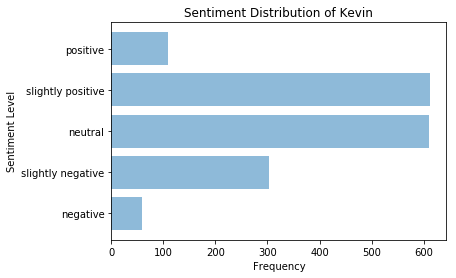

Enter the guessed sentiment number: 2


(Optional) Now, are we speaking to which season's Kevin?
Enter a number between 1 and 9: 


(Optional) Here are some words Kevin says a lot. Anything you'd like to talk about with Kevin ?


The top 15 words for Kevin are: 
michael, gon, mean, pam, jim, oscar, guys, man, time, hey, people, thing, day, love, way, 

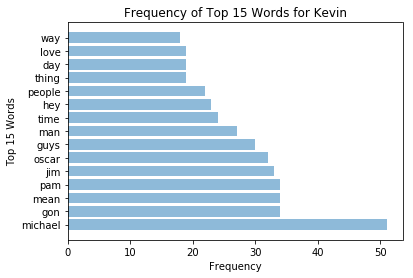

Enter the word you want to input: michael


Season: 7, Episode: 21, Scene: 16

Michael: Kevin, I have something for you.
Kevin: Oh!
Michael: You know who that is?
Kevin: Oh...
Michael: Don't be a caricature Kevin, never be a caricature. How did that feel when I tore that up?
Kevin: Better...
Michael: Good, stand up.You will be thin. You Won't drool over pizza like an animal anymore.
Kevin: But...
Michael: You will find love.
Kevin: Michael, I'm pretty much okay with who I am now.
Michael: Don't be. You should never settle for who you are.Oscar, Oscar, Oscar! Oscar, you are-
Andy: I just lost Porter Hardware! I just, I lost 'em!
Michael: Okay, you know what? Just do your best buddy! Okay, Oscar, you are very smart, and you have a gigantic education. And, I think of you as my scarecrow, because you gave me a brain. So that's why I made you this.
Oscar: Thank you Michael. It's beautiful.


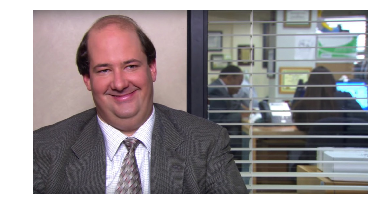

In [78]:
# user interface

# Headline
print('Welcome to Dunder Mifflin!\n')
print("Currently Michael, Dwight, Jim, Pam, Oscar, Andy, Angela, Kevin and Erin are in the office. \n")
time.sleep(1)

# required character name input
print(bcolors.BOLD+"Who would you like to talk to? "+bcolors.ENDC)
name = input("Enter the character name: ")
char_data = fetchCharacterData(name)
print('\n')

# required sentiment input
print(bcolors.BOLD+'How is '+ name + ' feeling today?\n')
print(bcolors.ENDC+'1: HIGH FIVING A MILLION ANGELS!')
print('2: I am running away from my responsibilities and IT FEELS GOOD!')
print('3: I have no strong feelings one way or another.')
print('4: I hate everything, just slightly.')
print('5: No god please no! NOOOOOOOOOO')
# sentiment visualization
visualizeSentiment(char_data,name)
time.sleep(1)
sentiment = input("Enter the guessed sentiment number: ")
# prepare sentiment dataframe
sentiment_data = fetchCharSentimentData(char_data,int(sentiment))
print('\n')

# optional inputs: word, season
print(bcolors.BOLD+"(Optional) Now, are we speaking to which season's " + name + "?"+bcolors.ENDC)
season = input("Enter a number between 1 and 9: ")
print('\n')

print(bcolors.BOLD+"(Optional) Here are some words " + name + " says a lot. Anything you'd like to talk about with "+ name + " ?"+bcolors.ENDC)
print('\n')
# word viz
visualizeTopWords(topWords,name)
time.sleep(1)
word = input("Enter the word you want to input: ")
print('\n')

# query results
result = input_handler(season,word,char_data,sentiment_data,name)

displayImg(name)

if(result == None):
    print("No result is found :/ Try Again!")
else:
    generateDialogue(result[0],result[1],result[2],result[3])

In [68]:
# testing
# line_list = list(data_topCast[data_topCast["speaker"] == "Michael"]["line_text"])
# line_list[3010]              